
# hw1

Robert McCulloch  
1/23/2022



# Train test/split, categorical variables, and transformations

In this homework we will explore some of the basic tools in applied statistics.
However, we will take a Machine Learning viewpoint in the our approach to model selection wil use a train/test split.

We will:

   - learn about the train/test split
   - see how to use a categorical regressor in a linear model
   - try the log transform on y
   - try a polynomial transformation of an x



First our imports:  

In [1]:
# numpy and pandas
import numpy as np
import pandas as pd
import math

#graphics with matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# model, train/test split, dummies (one-hot-encoding), rmse metric from scikit learn.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error

# Get the data

Let’s read in the used cars data.
We will just use the features mileage and color.

In [2]:
cd = pd.read_csv("https://bitbucket.org/remcc/rob-data-sets/downloads/susedcars.csv")
cd = cd[['price','mileage','color']]
cd['price'] = cd['price']/1000
cd['mileage'] = cd['mileage']/1000
cd.head()

price  mileage   color
0  43.995   36.858  Silver
1  44.995   46.883   Black
2  25.999  108.759   White
3  33.880   35.187   Black
4  34.895   48.153   Black

# train/test split

In our brief introduction to statistics in R and python we learned how run a multiple regression.  

One of the issues that often comes up in modeling is which features (or x variables) are important.  

Many people use the t statistics and associated p-values to guide them in their choice.  

In Machine Learning, we keep our focus on prediction since that is often the goal in practice.  

We want to choose the modeling approach that predicts the best.  
But how do we assess this?

As we will see, the basic way is to simply randomly split the data into two subsets.  
Estimate the model using one subset called the training data.  
Then see how well you predict on the other subset, the test data.  
Because you actually have the y values in the test data you can see how well your predictions worked.  

We will randomly split the data into train and test subsets.  
We will put 75% of the data in train and the remaining 25% in test.

Train/test splits are a very common thing in Machine Learning so there is a function to do this
in sklearn.

  

In [3]:
cdtr, cdte = train_test_split(cd,random_state=99, test_size=.25)
print('train dimension',cdtr.shape)
print('test dimension',cdte.shape)

train dimension (750, 3)
test dimension (250, 3)


Let's plot x=mileage vs. y=price in the training data just to make sure it looks correst. 

Text(0, 0.5, 'price')

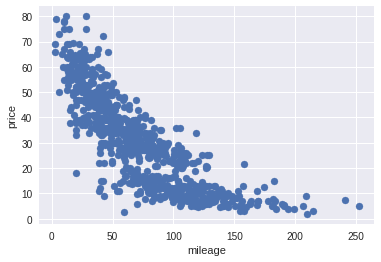

In [4]:
plt.scatter(cdtr['mileage'],cdtr['price'])
plt.xlabel('mileage'); plt.ylabel('price')

Looks ok!

Now we fit our model using the training data.
We will start by only using the feature mileage.

In [5]:
lm1 = LinearRegression(fit_intercept=True)
lm1.fit(cdtr[['mileage']],cdtr['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now we predict on the test data. 

In [6]:
yhtest = lm1.predict(cdte[['mileage']])

How did we do?  
We plot our predictions versus the actual prices in the test data.

Text(0, 0.5, 'price')

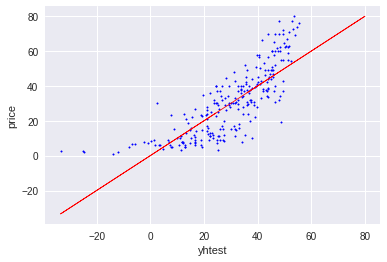

In [7]:
## plot y vs predicted on test
yy = np.concatenate([yhtest,cdte['price'].to_numpy()])
plt.plot(yy,yy,c='red',linewidth=.8)
plt.scatter(yhtest,cdte['price'],c='blue',s=2.5)
plt.xlabel('yhtest'); plt.ylabel('price')

Not so great.  
In particular, you will lose a lot of credibility if you predict a negative price.  

We can use a variety of numerical measures to summarize our predictive performance.  

Let's use rmse from sklearn.  

In [8]:
rmse = math.sqrt(mean_squared_error(yhtest,cdte['price']))
print(f'rmse using just mileage is {rmse:0.2f}')

rmse using just mileage is 11.65


Let's check the rmse. 

In [9]:
def rmse(y,yh):
    return(math.sqrt(np.mean((y-yh)**2)))

print(rmse(cdte['price'],yhtest))

11.647566500771871


How about the out of sample R-squared.  

In [10]:
np.corrcoef(cdte['price'],yhtest)**2

array([[1.        , 0.65067373],
       [0.65067373, 1.        ]])

# Is color any good ?

How about the categorical variable color?  
Can that feature help us predict the price of a car?  

How do we put color into a regression model?  
We can’t just put color, a coefficient times “red” does not mean anything!  

We will use **dummy variables** to put the categorical variable color into a linear regression model.  
This is often called **one hot encoding** in machine learning.  

Both pandas and sklearn have utilities to create the dummies.  Let's use sklearn.  

In [11]:
one_hot = LabelBinarizer()
cdumtr = one_hot.fit_transform(cdtr['color'])
cdumte = one_hot.fit_transform(cdte['color'])
print(cdtr['color'][:10])
cdumtr[:10]

644     Black
389     Black
999     other
125     Black
792    Silver
464    Silver
676     other
606     White
319    Silver
466     Black
Name: color, dtype: object


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

For each possible color, we create a dummy variable which is 1 if the car is that color and 0 otherwise.  
So, for example, the first column of cdumtr indicates which cars in the training data are black.  

Since we have 4 possible colors, we get four columns of dummy variables.  
The second dummy is for silver cars, the third dummy is for white cars, and the fourth dummy is for other colors.  

The trick is to then put any three of the dummy columns into a multiple regression.  
Let's drop the first dummy (the one for color black).  

We will create train and test arrays whose first column is mileage and next three columns are the color dummies.  

In [12]:
Xctr = np.hstack([cdtr.iloc[:,[1]].to_numpy(),cdumtr[:,1:4]])
Xcte = np.hstack([cdte.iloc[:,[1]].to_numpy(),cdumte[:,1:4]])
Xctr[:5]

array([[ 47.894,   0.   ,   0.   ,   0.   ],
       [ 27.295,   0.   ,   0.   ,   0.   ],
       [131.121,   0.   ,   0.   ,   1.   ],
       [ 12.097,   0.   ,   0.   ,   0.   ],
       [109.609,   1.   ,   0.   ,   0.   ]])

We can see that the first car is black since all the other dummies are zero and has mileage 47.9.  
Thus we can see that just using three of the four dummies is sufficient to identify the  color of the car.  

Now we can run the regression and get predictions.  

In [13]:
lm2 = LinearRegression(fit_intercept=True)
lm2.fit(Xctr,cdtr['price'])
yhtest = lm2.predict(Xcte)

Our model is actually:
$$
price = \beta_0 + \beta_1 mileage + \beta_2 D_{silver} + \beta_3 D_{white} + \beta_4 D_{other} + \epsilon
$$

In [14]:
print('intercept:',lm2.intercept_)
print('slopes:',lm2.coef_)

intercept: 57.212456451456745
slopes: [-0.34247931 -4.43507734 -0.38043861 -3.4692273 ]


Let's plotted the predictions versus mileage.

Text(0, 0.5, 'predictions using mileage and color')

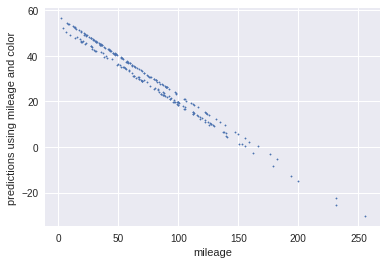

In [15]:
plt.scatter(cdte['mileage'],yhtest,s=2.0)
plt.xlabel('mileage'); plt.ylabel('predictions using mileage and color')

There are actually four parallel lines, one for each of the four colors.  
The dummies just adjust the intercepts.  
Does not look like color does a whole lot !!!!  

To see if color does anything, let's check the out-of-sample rmse.  

In [16]:
rmse = math.sqrt(mean_squared_error(yhtest,cdte['price']))
print(f'rmse using mileage and color is {rmse:0.2f}')


rmse using mileage and color is 11.39


The same as when we just used mileage.  

# log transform 

The possibility of a negative prediction for price was particularly disturbing.  

Let’s try logging y.  

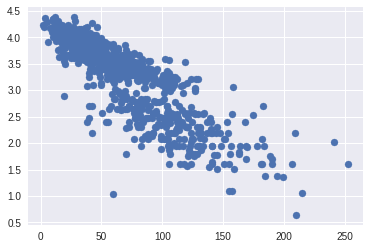

In [17]:
lprice = np.log(cdtr['price'])
plt.scatter(cdtr['mileage'],lprice)

Does this look better ?  

To predict price with this model we predict log price and then exponentiate.

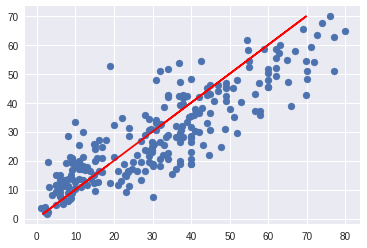

In [18]:
lm3 = LinearRegression(fit_intercept=True)
lm3.fit(cdtr[['mileage']],lprice)

lyhat = lm3.predict(cdte[['mileage']])
yhat = np.exp(lyhat)
plt.scatter(cdte['price'],yhat)
plt.plot(yhat,yhat,c='red')


What do you think ?  

# Quadratic term 

Text(0, 0.5, 'price')

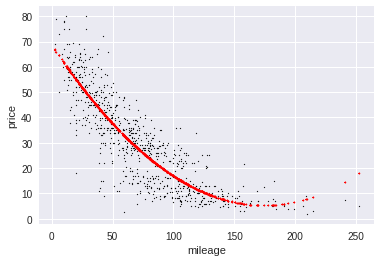

In [19]:
Xq = np.column_stack([cdtr['mileage'],cdtr['mileage']**2])
lm4 = LinearRegression(fit_intercept=True)
lm4.fit(Xq,cdtr['price'])
yhat = lm4.predict(Xq)

plt.scatter(cdtr['mileage'],cdtr['price'],marker='o',c='black',s=.9)
plt.scatter(cdtr['mileage'],yhat,marker=5,c='red',s=.9)
plt.xlabel('mileage'); plt.ylabel('price')


We are fitting the model:

$$
price = \beta_0 + \beta_1 \, mileage + \beta_2 \, mileage^2 + \epsilon
$$

What do you think ?

Homework:

Use out of sample performance (a train/test split) to decide which of these two models is best: 

- linear model of log(y) on mileage and color
- linear model of y on mileage, mileage squared, and color

Use out of sample rmse and graphics to compare the two models.